## Image classification with CNN

### Cats vs Dogs

Here we deal with the Kaggle Cats vs Dogs competition https://www.kaggle.com/c/dogs-vs-cats

Aim is to build a classifier to detect cats and dogs using PyTorch.

#### Things to learn:

* Transfer learning
* Using pre trained weights (done)
* Freezing layers and training a subset
* Precomputing activation functions to speed up training
* Saving and restoring models on filesystem
* Adaptive learning rate


#### References

* https://github.com/pytorch/examples/blob/master/imagenet/main.py
* http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* https://github.com/Spandan-Madan/Pytorch_fine_tuning_Tutorial

### Import required libraries

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler
import os
import shutil

# Custom code
import utility

%matplotlib inline

### Constants

Download the dataset from http://files.fast.ai/data/dogscats.zip and update the 'data_path' below to point to the unzipped location.

In [3]:
data_path = "/home/as/datasets/fastai.dogscats"
img_size = 224 
num_workers = 4 # For DataLoader
checkpoint_folder = 'checkpoints'

In [4]:
if not os.path.exists(checkpoint_folder):
    os.mkdir(checkpoint_folder)

### Explore dataset

In [5]:
!ls {data_path}/

models	sample	test  test1  tmp  train  valid


In [6]:
train_files = !ls {data_path}/train/cats

In [7]:
train_files[:9]

['cat.0.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg',
 'cat.10004.jpg',
 'cat.10005.jpg',
 'cat.10006.jpg',
 'cat.10007.jpg']

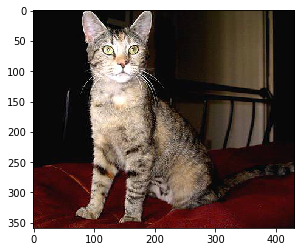

In [8]:
img = plt.imread(f'{data_path}/train/cats/{train_files[1]}')
plt.imshow(img)

In [9]:
img.shape # Not in good shape, we need to convert it to a standard size

(359, 431, 3)

### Prepare the data loaders

We will use the ImageFolder class to fetch our data. It can dynamically load hugh datasets by reading them on the fly.

Explore ImageFolder here: https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py

Before that, let's create the transforms that we intend to apply to our images. Let's try two of them:
* One is vanilla
* Other is with data augmentation

In [10]:
# These should match the values used for the model we choose (we are choosing resnet34 here)
normaliser = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# This is a vanilla transformation
trans = transforms.Compose([transforms.Scale((img_size, img_size)), 
                            transforms.ToTensor(),
                            normaliser])

# This is a augmented transformation
trans_augmented = transforms.Compose([transforms.Scale((img_size, img_size)), 
                                      transforms.RandomHorizontalFlip(),
                                      # Add some more here
                                      transforms.ToTensor(),
                                      normaliser]) 

# Transformation for Validation and Test set
trans_validation = transforms.Compose([transforms.Scale((img_size, img_size)), 
                                      transforms.ToTensor(),
                                      normaliser]) 

In [11]:
from torchvision.datasets.folder import ImageFolder

# Vanilla dataset
train_images = ImageFolder(f'{data_path}/train', transform=trans)

# Augmented dataset
train_images_augmented = ImageFolder(f'{data_path}/train', transform=trans_augmented)

# For valid and test datasets
valid_images = ImageFolder(f'{data_path}/valid', transform=trans_validation)

In [12]:
print(train_images.classes)
print(train_images.class_to_idx)
train_images.imgs[:3]

['cats', 'dogs']
{'cats': 0, 'dogs': 1}


[('/home/as/datasets/fastai.dogscats/train/cats/cat.0.jpg', 0),
 ('/home/as/datasets/fastai.dogscats/train/cats/cat.1.jpg', 0),
 ('/home/as/datasets/fastai.dogscats/train/cats/cat.10.jpg', 0)]

Ok, now that we have our datasets defined, the following creates dataloaders based on the batch size passed. We want to try with different batch sizes.

In [13]:
def get_loaders(batch_size):
    train_image_loader = torch.utils.data.DataLoader(train_images, 
                                                     batch_size=batch_size, 
                                                     shuffle=True, 
                                                     num_workers=num_workers, 
                                                     pin_memory=True) # For speedup, not always guaranteed

    train_image_aug_loader = torch.utils.data.DataLoader(train_images_augmented, 
                                                         batch_size=batch_size, 
                                                         shuffle=True, 
                                                         num_workers=num_workers, 
                                                         pin_memory=True) # For speedup, not always guaranteed

    valid_image_loader = torch.utils.data.DataLoader(valid_images, 
                                                     batch_size=batch_size, 
                                                     shuffle=True, 
                                                     num_workers=num_workers, 
                                                     pin_memory=True) # For speedup, not always guaranteed

    return train_image_loader, valid_image_loader, train_image_aug_loader

### Use a pre-trained model to create this classifier

In [14]:
import torchvision.models as models

In [15]:
# Let's see which all models are available to us from PyTorch

print('We choose from these pre trained models in PyTorch')
print('--------------------------------------------------')
for model in models.__dict__:
    if model.islower() and not model.startswith("__") and callable(models.__dict__[model]):
        print(model)

We choose from these pre trained models in PyTorch
--------------------------------------------------
alexnet
resnet18
resnet34
resnet50
resnet101
resnet152
vgg11
vgg11_bn
vgg13
vgg13_bn
vgg16
vgg16_bn
vgg19_bn
vgg19
squeezenet1_0
squeezenet1_1
inception_v3
densenet121
densenet169
densenet201
densenet161


In [16]:
# Put benchmark on
cudnn.benchmark = True

### The Experiment

Now what I have done here is created a function called experiment which will do the training based on the parameters passed. We can then experiment with various combinations to see the effect of each one.

In [17]:
# With this function, we can experiment with various parameter combinations

def experiment(model, batch_size=128, num_epochs=5, init_lr=0.01, momentum=0.9, weight_decay=1e-4, 
               use_aug=False, checkpoint_file_prefix='resnet34'):
    
    # Fetch data loaders for the batch size passed
    train_image_loader, valid_image_loader, train_image_aug_loader = get_loaders(batch_size)
    
    # Are we using vanilla or augmented data?
    if use_aug:
        train_loader = train_image_aug_loader
    else:
        train_loader = train_image_loader
    
    print('Total training instances:', len(train_loader.dataset))
    print('Total validation instances:', len(valid_image_loader.dataset))
    print('Classes:', train_image_loader.dataset.classes)
    
    # We will track the best validation precision available, and the checkpoint file it is contained in
    best_precision = 0 
    best_filepath = None
    
    # Standard stuff
    # effective_lr = lr # We will be decaying this
    
    # Now we can also try with different optimizers, for another day
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(model.fc.parameters(), lr=init_lr, momentum=momentum, weight_decay=weight_decay)
    # The learning rate scheduler - Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    for e in range(num_epochs):
        
        #################################################
        # Train
        #################################################
        model.train()
        exp_lr_scheduler.step()
        train_losses = utility.AverageMeter()
        train_top1 = utility.AverageMeter()
        train_top5 = utility.AverageMeter()
    
        for i, (input, target) in enumerate(train_loader):

            input_var = autograd.Variable(input.cuda())
            target_var = autograd.Variable(target.cuda())
            output = model(input_var).cuda()
            loss = criterion(output, target_var)
        
            
            prec1, prec5 = utility.accuracy(output.data, target_var.data, batch_size, topk=(1, 5))
            train_losses.update(loss.data[0], input.size(0))
            train_top1.update(prec1[0], input.size(0))
            train_top5.update(prec5[0], input.size(0))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print('.', end='')
    
        #################################################
        # Validate
        #################################################
        # Every epoch we calculate the validation accuracy
        model.eval()
        val_losses = utility.AverageMeter()
        val_top1 = utility.AverageMeter()
        val_top5 = utility.AverageMeter()
        
        for i, (input, target) in enumerate(valid_image_loader):
            
            input_var = autograd.Variable(input.cuda())
            target_var = autograd.Variable(target.cuda())
            output = model(input_var)
            loss = criterion(output, target_var)
            
            prec1, prec5 = utility.accuracy(output.data, target_var.data, batch_size, topk=(1, 5))
            val_losses.update(loss.data[0], input.size(0))
            val_top1.update(prec1[0], input.size(0))
            val_top5.update(prec5[0], input.size(0))
            print('.', end='')
            
        print(e, 'Training', train_losses.val, 'Validation', val_losses.val)
        print(e, 'Training', train_top1.avg, 'Validation', val_top1.avg)
        
        #################################################
        # Checkpointing
        #################################################
        # Save the model if best so far
        is_best = val_top1.avg > best_precision
        best_precision = max(val_top1.avg, best_precision)
        if is_best:
            state = utility.encode_state(model_name, model.state_dict(), optimizer.state_dict(), e, best_precision)
            best_filepath = utility.save_model(checkpoint_folder, state, e)
        
        # Adjust learning rate - every 10 epocs, decay the learning rate by 10%
        #effective_lr = lr * (0.1 ** (e // 10))
        #for param_group in optimizer.param_groups:
        #    param_group['lr'] = effective_lr
            
    return best_filepath

### Now let's experiment!

Let's use the pretrained model as a feature extractor. We will freeze all layers except the last fully connected layer

In [18]:
# Let's create the model. In case you want to experiment with a different model
# change here.    
model_name = 'resnet34' # Let's choose this model
model = models.__dict__[model_name](pretrained=True)

# We could have also done it this way to choose resnet34 specifically:
# model = models.resnet34(pretrained=True)

# "Data Parallelism is when we split the mini-batch of samples into multiple smaller 
# mini-batches and run the computation for each of the smaller mini-batches in parallel."
#
# This will benifit only when you have multiple GPU's
# http://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html
# model = torch.nn.DataParallel(model).cuda()

# Finetune model - freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Reconfigure the last layer to have
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) # 10 classes
model = model.cuda()

best_checkpoint = experiment(model, batch_size=128, num_epochs=5, init_lr=0.01, momentum=0.9, 
                             weight_decay=1e-4, use_aug=True)

Total training instances: 23000
Total validation instances: 2000
Classes: ['cats', 'dogs']
....................................................................................................................................................................................................0 Training 0.0714866891503334 Validation 0.05943644046783447
0 Training 96.45652173647673 Validation 98.3
....................................................................................................................................................................................................1 Training 0.03000517375767231 Validation 0.015714406967163086
1 Training 98.02173911451257 Validation 98.25
....................................................................................................................................................................................................2 Training 0.03221186622977257 Validation 0.0918566957116127
2 Training 98.3086956362517 Validation 98.45


### Test with test set

In [30]:
best_checkpoint = 'checkpoints/checkpoint_2.pth.tar'

In [39]:
def show_image(img):
    inp = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

cat


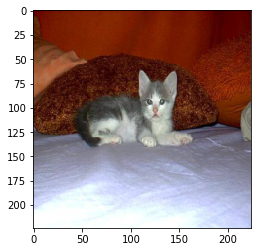

cat


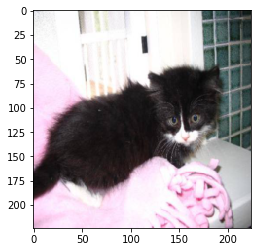

cat


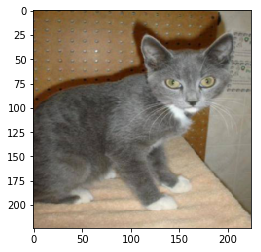

dog


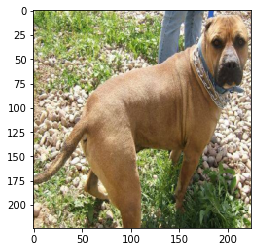

dog


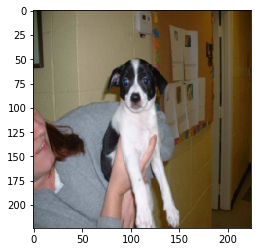

In [48]:
model_name, model_state_dict, optimizer_state_dict, epoch_num, best_precision = utility.load_model(best_checkpoint)

test_model = models.resnet34(pretrained=True)
num_ftrs = test_model.fc.in_features
test_model.fc = nn.Linear(num_ftrs, 10) # 10 classes
test_model = test_model.cuda()
test_model.load_state_dict(model_state_dict)

test_images = utility.TestFolder(f'{data_path}/test1', "jpg", transform=trans_validation)

test_image_loader = torch.utils.data.DataLoader(test_images,
                                                batch_size=1,
                                                shuffle=True,
                                                num_workers=num_workers,
                                                pin_memory=True)

to_show = 4
for i, data in enumerate(test_image_loader):
    data_gpu = autograd.Variable(data.cuda())
    
    outputs = test_model(data_gpu)
    _, preds = torch.max(outputs.data, 1)
    c = preds[0]
    if c == 0:
        print('cat')
    else:
        print('dog')
    show_image(data_gpu.cpu().data[0])
    to_show -= 1
    if to_show < 0:
        break